- Task 1: Import data, analyse data for columns,
- Task 2: Split train test,
- Task 3: transformations (after splitting, because we dont want data leakage),  binning (If possible?), then PCA
- Task 4: Define a model # we will use unsupervised techniques here (KNN, )

In [1]:
#store wordlist.txt into variable named wordlist
f = open("wordlist.txt")
train_test_wordlist = eval(f.read())

#store each review TFIDF as a dict into variable named review_TFIDF
f = open("fileTFIDFdict.txt")
train_test_review_TFIDF = eval(f.read())

#rating of each review
f = open("rating_score.txt")
train_test_rating_score = eval(f.read()) #contain file realname and rating score as dict

In [2]:
#check if train_test_wordlist contain unique words
len(train_test_wordlist) == len(set(train_test_wordlist))

True

# Training and Testing Data

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import words
#nltk.download('words')

In [4]:
def data_preparation(review_TFIDF, wordlist, rating_score):
    
    train_test_data = pd.DataFrame(review_TFIDF).transpose()
    train_test_data = train_test_data.set_axis(wordlist, axis = 1) # 3238 columns and 60 rows (words and file realname)
    train_test_target = pd.DataFrame([rating_score]).transpose() #1 columns and 60 rows (rating score and file realname)
    train_test_target = np.where(train_test_target > 5, 1, 0) #1 for positive review, 0 for negative review

    #remove words that do not appear in the English dictionary using nltk.corpus.words.words() dataset
    #english_words = set(words.words())
    #train_test_data = train_test_data.loc[:, train_test_data.columns.isin(english_words)]
    
    #Train test split of data
    X_train, X_test, y_train, y_test = train_test_split(train_test_data, train_test_target, test_size = 0.2, random_state = 1)
    return X_train, X_test, y_train, y_test

In [5]:
train_test_data = pd.DataFrame(train_test_review_TFIDF).transpose()
train_test_data = train_test_data.set_axis(train_test_wordlist, axis = 1) 
train_test_data


train_test_target = pd.DataFrame([train_test_rating_score]).transpose() #1 columns and 60 rows (rating score and file realname)
train_test_target = np.where(train_test_target > 5, 1, 0) #1 for positive review, 0 for negative review
np.unique(train_test_target, return_counts = True)

#calculate the number of positive and negative reviews in the dataset
train_test_target = pd.DataFrame(train_test_target)
train_test_target.value_counts()

0
0    30
1    30
Name: count, dtype: int64

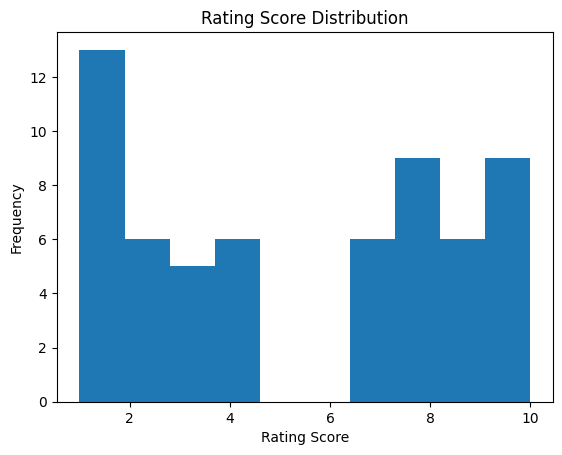

In [20]:
# create a historgram of the rating score
import matplotlib.pyplot as plt
plt.hist(train_test_rating_score.values(), bins = 10)
plt.xlabel('Rating Score')
plt.ylabel('Frequency')
plt.title('Rating Score Distribution')
plt.show()

# Modelling

## Part 1: Normalised data model with SVC

In [45]:
X_train, X_test, y_train, y_test = data_preparation(train_test_review_TFIDF, train_test_wordlist, train_test_rating_score)

# Normalisation of data,we use maxAbs Scaler to scale data since, only positive values are present in the data
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#---------------------------------SVC Model---------------------------------

#Define data model with PCA and model SVC:
def model_data_SVC(X_train, X_test, y_train, y_test):

    # Applying PCA to reduce the dimensionality of the data
    pca = PCA(n_components = 0.90, svd_solver = 'full') # 0.90 variance is retained
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # Linear SVC
    clf = SVC(random_state=1)

    ## Grid search
    param_grid = {'C': [1, 5, 10],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'degree': [1,2,4,6,7],}

    gridClf = GridSearchCV(clf, param_grid, cv=2,verbose=0)
    classifier_SVC_norm = gridClf.fit(X_train, y_train.ravel())

    classifier_SVC_norm.best_score_

    tn, fp, fn, tp = confusion_matrix(y_test, classifier_SVC_norm.predict(X_test)).ravel()
    
    #print(classifier_SVC_norm.best_score_, classifier_SVC_norm.best_params_, (tp+tn)/(tp+tn+fp+fn)*100)

    return classifier_SVC_norm.best_score_, classifier_SVC_norm.best_params_, (tp+tn)/(tp+tn+fp+fn)*100 


In [166]:
model_data_SVC(X_train, X_test, y_train, y_test)

(0.6458333333333334,
 {'C': 1, 'degree': 1, 'kernel': 'poly'},
 83.33333333333334)

## Part 2: Unnormalised data with PCA with SVC model:

In [74]:
# unnormalised data set for training and testing:
X_train, X_test, y_train, y_test = data_preparation(train_test_review_TFIDF, train_test_wordlist, train_test_rating_score)

#Apply model_data_SVC function to unnormalised data
model_data_SVC(X_train, X_test, y_train, y_test)

(0.6041666666666667, {'C': 1, 'degree': 1, 'kernel': 'sigmoid'}, 75.0)

## Part 3: Normalised data without PCA with SVC model:


In [75]:
#Define data model with PCA and model SVC:
def model_data_SVC(X_train, X_test, y_train, y_test):
    # Applying PCA to reduce the dimensionality of the data
    #pca = PCA(n_components = 0.90, svd_solver = 'full') # 0.90 variance is retained
    #X_train = pca.fit_transform(X_train)
    #X_test = pca.transform(X_test)

    # Linear SVC
    clf = SVC(random_state=1)

    ## Grid search
    param_grid = {'C': [1, 5, 10],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'degree': [1,2,4,6,7],}

    gridClf = GridSearchCV(clf, param_grid, cv=2,verbose=0)
    classifier_SVC_norm = gridClf.fit(X_train, y_train.ravel())

    classifier_SVC_norm.best_score_

    tn, fp, fn, tp = confusion_matrix(y_test, classifier_SVC_norm.predict(X_test)).ravel()
    
    #print(classifier_SVC_norm.best_score_, classifier_SVC_norm.best_params_, (tp+tn)/(tp+tn+fp+fn)*100)

    return classifier_SVC_norm.best_score_, classifier_SVC_norm.best_params_, (tp+tn)/(tp+tn+fp+fn)*100 


In [76]:
X_train, X_test, y_train, y_test = data_preparation(train_test_review_TFIDF, train_test_wordlist, train_test_rating_score)
# Normalisation of data,we use maxAbs Scaler to scale data since, only positive values are present in the data
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [77]:
model_data_SVC(X_train, X_test, y_train, y_test)

(0.75, {'C': 1, 'degree': 1, 'kernel': 'linear'}, 66.66666666666666)

## Part 4: Unnormalised data without PCA and with SVC:

In [78]:
X_train, X_test, y_train, y_test = data_preparation(train_test_review_TFIDF, train_test_wordlist, train_test_rating_score)

#Unnormalised data without PCA and with SVC:
model_data_SVC(X_train, X_test, y_train, y_test)

(0.7083333333333334,
 {'C': 5, 'degree': 1, 'kernel': 'sigmoid'},
 58.333333333333336)

In [81]:
## Create gradient-boosted trees
from sklearn.ensemble import GradientBoostingClassifier
def model_data_gradient_boosted_trees(X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier(random_state=1)
    pca = PCA(n_components = 0.90, svd_solver = 'full') # 0.90 variance is retained
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    ## Grid search
    param_grid = {'n_estimators': [100, 200],
                  'learning_rate': [0.1, 0.05],
                  'max_depth': [3,8,12],}

    gridClf = GridSearchCV(clf, param_grid, cv=2,verbose=0)
    classifier_gradient_boosted_trees = gridClf.fit(X_train, y_train.ravel())

    classifier_gradient_boosted_trees.best_score_

    tn, fp, fn, tp = confusion_matrix(y_test, classifier_gradient_boosted_trees.predict(X_test)).ravel()
    
    #print(classifier_gradient_boosted_trees.best_score_, classifier_gradient_boosted_trees.best_params_, (tp+tn)/(tp+tn+fp+fn)*100)

    return classifier_gradient_boosted_trees.best_score_ * 100, classifier_gradient_boosted_trees.best_params_, (tp+tn)/(tp+tn+fp+fn)*100


In [66]:
X_train, X_test, y_train, y_test = data_preparation(train_test_review_TFIDF, train_test_wordlist, train_test_rating_score)
model_data_gradient_boosted_trees(X_train, X_test, y_train, y_test)

(72.91666666666667,
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
 66.66666666666666)

# ===NEW CHAPTER===
# Create pipeline from model above

In [6]:
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import GradientBoostingClassifier
# we have: #with set english word = False
# normalised data model with PCA and model SVC: 83.33 (Test)
# unnormalised data model with PCA and model SVC: (75.0) (test)
# normalised data model without PCA and with SVC: (66.66) (test)
# unnormalised data model without PCA and with SVC: (83.33) (test)
# unnormalised data model with decision tree: 33.33 (test)
# unnormalised data model with gradient boosted trees: 58.33 (test)


# we have: #with set english word = True
# normalised data model with PCA and model SVC: (66.66) (Test)
# unnormalised data model with PCA and model SVC: (75.0) (test)
# normalised data model without PCA and with SVC: (66.66) (test)
# unnormalised data model without PCA and with SVC: (58.33) (test)
# unnormalised data model with decision tree: (66.66) (test)
# unnormalised data model with gradient boosted trees: (66.66) (test)

# goes from:
# set English words -> 
# scaling data -> PCA/no PCA -> 
# models (SVC, decision tree, gradient boosted trees)


In [7]:
def data_preparation(review_TFIDF, wordlist, rating_score, remove_non_english_words):
    
    train_test_data = pd.DataFrame(review_TFIDF).transpose()
    train_test_data = train_test_data.set_axis(wordlist, axis = 1) # 3238 columns and 60 rows (words and file realname)
    train_test_target = pd.DataFrame([rating_score]).transpose() #1 columns and 60 rows (rating score and file realname)
    train_test_target = np.where(train_test_target > 5, 1, 0) #1 for positive review, 0 for negative review

    #remove words that do not appear in the English dictionary using nltk.corpus.words.words() dataset
    if remove_non_english_words == True:
        english_words = set(words.words())
        train_test_data = train_test_data.loc[:, train_test_data.columns.isin(english_words)]
    
    #Train test split of data
    X_train, X_test, y_train, y_test = train_test_split(train_test_data, train_test_target, test_size = 0.2, random_state = 1)
    return X_train, X_test, y_train, y_test

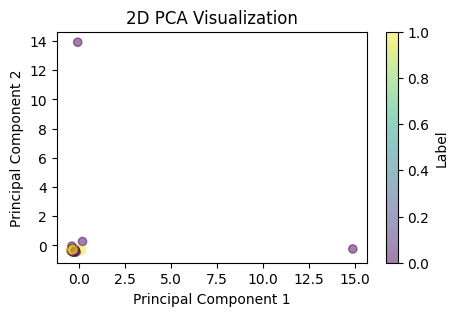

In [8]:
# Prepare Data
X_train, X_test, y_train, y_test = data_preparation(
    train_test_review_TFIDF, train_test_wordlist, train_test_rating_score, remove_non_english_words=False
)

# Scale Data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA (Reduce to 2D for Visualization)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Convert to DataFrame for Plotly
import pandas as pd
df_pca = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df_pca['Label'] = y_train

# Plot 2D PCA results using Plotly
#fig = px.scatter(df_pca, x='PC1', y='PC2', color=df_pca['Label'].astype(str),
#                 title="2D PCA Visualization", labels={'color': 'Label'})

#fig.show()

# Optional: Matplotlib Version
plt.figure(figsize=(5,3))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Visualization")
plt.colorbar(label="Label")
plt.show()


In [9]:
#count the total number of 0 and 1 in the following train varaible:
np.unique(y_train, return_counts=True) # 24 positive 24 negative
np.unique(y_test, return_counts=True) # 6 positive 6 negative

(array([0, 1]), array([6, 6], dtype=int64))

72.91666666666667 {'maxabsscaler': MaxAbsScaler(), 'model': SVC(random_state=1), 'model__C': 1, 'model__degree': 1, 'model__kernel': 'poly', 'pca': PCA(n_components=0.9, svd_solver='full')} 83.33333333333334


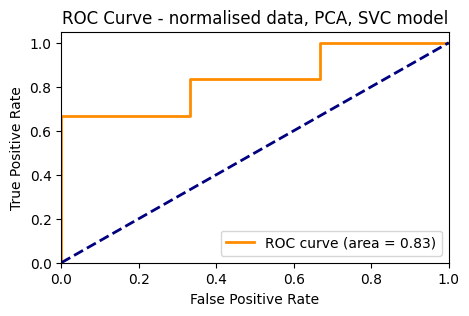

In [12]:
#part 1: with non-English words -> normalised & unnormalised data model with & without PCA using model SVC
#prepare data
X_train, X_test, y_train, y_test = data_preparation(train_test_review_TFIDF, 
                                                    train_test_wordlist, 
                                                    train_test_rating_score,
                                                    remove_non_english_words=False)

#make pipeline for both models
pipe1 = Pipeline([('maxabsscaler', MaxAbsScaler()), 
                 ('pca', PCA()), 
                 ('model', SVC())])
#check params of pipe1 and pipe2 for similarity


param_grid1 = [{
                'maxabsscaler' : [None, MaxAbsScaler()],
                'pca' : [None, PCA(n_components = 0.90, svd_solver = 'full')],
                'model': [SVC(random_state=1)],
                'model__C': [1, 5, 10],
                'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'model__degree': [1,2,4,6,7],
               },
               {
                'maxabsscaler' : [None, MaxAbsScaler()],
                'pca': [None, PCA(n_components = 0.90, svd_solver = 'full')],
                'model': [GradientBoostingClassifier(random_state=1)],
                'model__n_estimators': [100, 200],
                'model__learning_rate': [0.1, 0.05],
                'model__max_depth': [3,8,12, 500],
               }]


#grid1 = GridSearchCV(pipe1, param_grid = param_grid1, cv=2, verbose=0).fit(X_train, y_train.ravel())
print(grid1.best_score_*100, grid1.best_params_, grid1.score(X_test, y_test.ravel())*100)

#----------------------
#return grid1 best score bof each models and its parameters
#the difference between PCA in manual approach and pipeline approach
#is that PCA is not applied to the test data in the pipeline approach
#BE AWARE OF THIS: https://scikit-learn.org/stable/common_pitfalls.html
#----------------------------------------------------------------------


#------ROC CURVE, AUC Score----------------------------------------------
from sklearn.metrics import roc_curve, auc

# Get probability scores of grid 1
y_score = grid1.decision_function(X_test)

#Compute ROC curve and ROC area 
fpr, tpr, _ = roc_curve(y_test.ravel(), y_score)
roc_auc = auc(fpr, tpr)

#calculate Gini coefficient
gini_coefficient = 2*roc_auc - 1
gini_coefficient #which equals to 0.67

# Plot ROC curve
plt.figure(figsize = (5,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - normalised data, PCA, SVC model')
plt.legend(loc="lower right")
plt.show()



70.83333333333334 {'maxabsscaler': None, 'model': SVC(random_state=1), 'model__C': 5, 'model__degree': 1, 'model__kernel': 'sigmoid', 'pca': None} 58.333333333333336


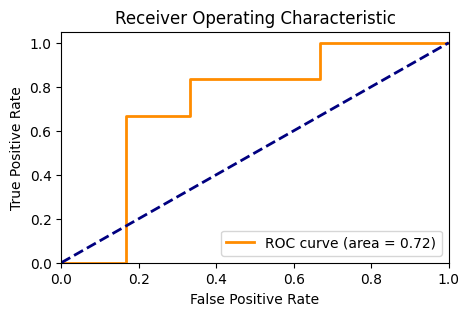

In [ ]:
#part 1: without non-English words -> normalised & unnormalised data model with & without PCA using model SVC
#prepare data
X_train, X_test, y_train, y_test = data_preparation(train_test_review_TFIDF, 
                                                    train_test_wordlist, 
                                                    train_test_rating_score,
                                                    remove_non_english_words=True)
              
#grid2 = GridSearchCV(pipe1, param_grid = param_grid1, cv=2, verbose=0).fit(X_train, y_train.ravel())
print(grid2.best_score_*100, grid2.best_params_, grid2.score(X_test, y_test.ravel())*100)

#----------------------
#return grid2 best score bof each models and its parameters
#the difference between PCA in manual approach and pipeline approach
#is that PCA is not applied to the test data in the pipeline approach
#BE AWARE OF THIS: https://scikit-learn.org/stable/common_pitfalls.html
#----------------------------------------------------------------------


#------ROC CURVE, AUC Score----------------------------------------------
from sklearn.metrics import roc_curve, auc

# Get probability scores of grid 1
y_score = grid2.decision_function(X_test)

#Compute ROC curve and ROC area 
fpr, tpr, _ = roc_curve(y_test.ravel(), y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize = (5,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ')
plt.legend(loc="lower right")
plt.show()


In [11]:
cv_results_df = pd.DataFrame(grid1.cv_results_)
cv_results_df.sort_values(by = 'mean_test_score', ascending = False).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_maxabsscaler,param_model,param_model__C,param_model__degree,param_model__kernel,param_pca,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
123,0.042822,0.001484,0.010362,0.000607,MaxAbsScaler(),SVC(random_state=1),1,1,poly,"PCA(n_components=0.9, svd_solver='full')",NaN,NaN,NaN,"{'maxabsscaler': MaxAbsScaler(), 'model': SVC(...",0.625000,0.833333,0.729167,0.104167,1
55,0.025343,0.000614,0.007779,0.000759,None,SVC(random_state=1),5,2,sigmoid,"PCA(n_components=0.9, svd_solver='full')",NaN,NaN,NaN,"{'maxabsscaler': None, 'model': SVC(random_sta...",0.708333,0.708333,0.708333,0.000000,2


In [ ]:
#now predict the following sentence:
sentence = ["I don't like this movie, it is bad, boring and the acting is terrible",
            "The game was done amazingly, the graphics though were quite average, however the gameplay was absolutely stunning",
            "While the iPhone boasts sleek design and powerful performance, its lack of innovation in recent updates makes it feel like an overpriced incremental upgrade",
            "Fast fashion brands offer affordability and trendy styles, yet their unsustainable practices and exploitative labor conditions raise serious ethical concerns."]

#predict the sentence
y_sentence = [0,1,0,0] #positive review
#convert the above sentence into a dataframe with the same columns as the training data

for row_idx, row in enumerate(sentence):
    sentence_TFIDF = {}
    for word in X_train:
        sentence_TFIDF[word] = 0
        if word in sentence[row_idx]:
            sentence_TFIDF[word] = 1
    sentence_TFIDF = pd.DataFrame(sentence_TFIDF, index = [0])

    #vectoriser
    from sklearn.feature_extraction.text import TfidfVectorizer

    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(sentence_TFIDF)
    new_tfidf_vector = vectorizer.transform([sentence[row_idx]])
    new_tfidf_df = pd.DataFrame(new_tfidf_vector.toarray(), columns = vectorizer.get_feature_names_out())
    new_tfidf_df = new_tfidf_df.reindex(columns = X_train.columns, fill_value = 0)

    #predict the sentence
    print(grid2.predict(new_tfidf_df) == y_sentence[row_idx])

[ True]
[ True]
[False]
[False]


In [ ]:
# 